## 引用Keras 套件

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape
from keras.layers import Flatten, BatchNormalization, Dense, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

Using TensorFlow backend.


## 读取图片数据

In [3]:
def load_dataset(dataset_path, batch_size, image_shape):
    dataset_generator = ImageDataGenerator()
    dataset_generator = dataset_generator.flow_from_directory(
        dataset_path, target_size=(image_shape[0], image_shape[1]),
        batch_size=batch_size,
        class_mode=None)

    return dataset_generator

## 建立生成器 (Generator)

In [4]:
def build_generator():

    model = Sequential()

    model.add(Dense(units=4 * 4 * 512,
                        input_shape=(1, 1, 100)))
    model.add(Reshape(target_shape=(4, 4, 512)))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=256, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=64, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(filters=3, kernel_size=(5, 5),
                                  strides=(2, 2), padding='same'))
    model.add(Activation('tanh'))
    model.summary()
    
    optimizer = Adam(lr=0.00015, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=None)

    return model

## 建立鉴别器 (Discriminator)

In [9]:
def build_discriminator():

    model = Sequential()
    
    image_shape = (64, 64, 3)
    model.add(Conv2D(filters=64, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             input_shape=(image_shape)))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(filters=128, kernel_size=(5, 5),
                             strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(filters=256, kernel_size=(5, 5),
                             strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(filters=512, kernel_size=(5, 5),
                             strides=(2, 2), padding='same'))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))

    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()

    optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=None)

    return model

## 图片取样

In [10]:
def sample_images(generated_images, epoch):

    plt.figure(figsize=(8, 8), num=2)
    gs1 = gridspec.GridSpec(8, 8)
    gs1.update(wspace=0, hspace=0)

    for i in range(generated_images.shape[0]):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        image = generated_images[i, :, :, :]
        image += 1
        image *= 127.5
        fig = plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    plt.tight_layout()
    save_name = 'images/generatedSamples_epoch' + str(
        epoch + 1) + '.png'

    plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
    plt.pause(0.0000000001)
    plt.show()

## 建立DCGAN

In [11]:
# 建立生成器
generator = build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 1, 8192)        827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_7 (Activation)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_8 (Activation)    (None, 8, 8, 256)         0         
__________

In [12]:
## 建立鉴别器
discriminator = build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 8, 256)         1024      
__________

In [13]:
# 堆叠 Generator 與 Discriminator
gan = Sequential()

# 只训练生成器
discriminator.trainable = False
gan.add(generator)
gan.add(discriminator)

optimizer = Adam(lr=0.00015, beta_1=0.5)
gan.compile(loss='binary_crossentropy', optimizer=optimizer,
                    metrics=None)

## 读取明星脸部图片

In [14]:
dataset_path = 'faces/'
batch_size   =  64
image_shape  = (64, 64, 3)

# 读取明星脸部图片
dataset_generator = load_dataset(dataset_path, batch_size, image_shape)

Found 413 images belonging to 3 classes.


## 初始化参数

In [15]:
number_of_batches  = int(dataset_generator.samples / batch_size)
adversarial_loss   = np.empty(shape=1)
discriminator_loss = np.empty(shape=1)
epochs = 250

## 训练DCGAN

Epoch 1 / 250:
 generator loss 7.656831741333008 | discriminator loss 3.1266746520996094 
 generator loss 9.087723731994629 | discriminator loss 2.007567882537842 
 generator loss 0.8474293947219849 | discriminator loss 2.693070888519287 
 generator loss 9.797412872314453 | discriminator loss 6.612872123718262 
 generator loss 14.112260818481445 | discriminator loss 2.6089396476745605 
 generator loss 1.8516607284545898 | discriminator loss 2.1678786277770996 
Epoch 2 / 250:
 generator loss 14.137665748596191 | discriminator loss 8.86202335357666 
 generator loss 14.462331771850586 | discriminator loss 2.5799808502197266 
 generator loss 14.406957626342773 | discriminator loss 2.2351090908050537 
 generator loss 14.537721633911133 | discriminator loss 2.1957435607910156 
 generator loss 14.428348541259766 | discriminator loss 2.276625633239746 
 generator loss 14.597970008850098 | discriminator loss 2.128072738647461 
Epoch 3 / 250:
 generator loss 14.504502296447754 | discriminator lo

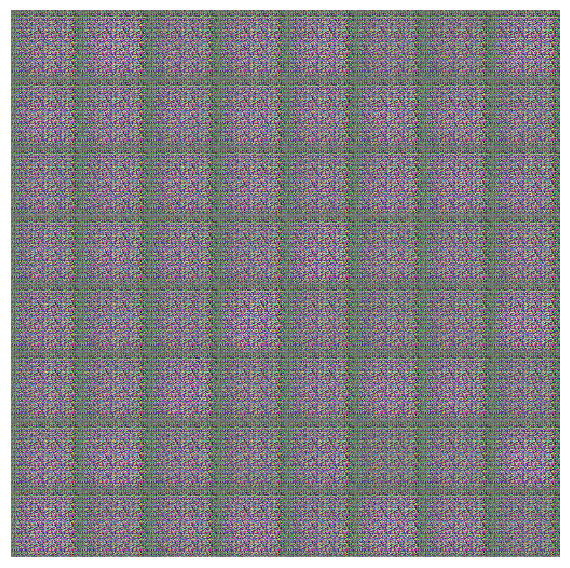

Epoch 6 / 250:
 generator loss 14.511805534362793 | discriminator loss 1.9643380641937256 
 generator loss 14.394821166992188 | discriminator loss 2.1313838958740234 
 generator loss 14.500255584716797 | discriminator loss 2.120741844177246 
 generator loss 14.580424308776855 | discriminator loss 1.8764320611953735 
 generator loss 14.528887748718262 | discriminator loss 1.8601325750350952 
 generator loss 14.473554611206055 | discriminator loss 2.0056443214416504 
Epoch 7 / 250:
 generator loss 14.494826316833496 | discriminator loss 2.111802816390991 
 generator loss 14.59079360961914 | discriminator loss 1.97395658493042 
 generator loss 14.569990158081055 | discriminator loss 2.2016377449035645 
 generator loss 14.501462936401367 | discriminator loss 1.954942226409912 
 generator loss 14.455130577087402 | discriminator loss 1.9068167209625244 
 generator loss 14.470839500427246 | discriminator loss 2.0104312896728516 
Epoch 8 / 250:
 generator loss 14.490814208984375 | discriminato

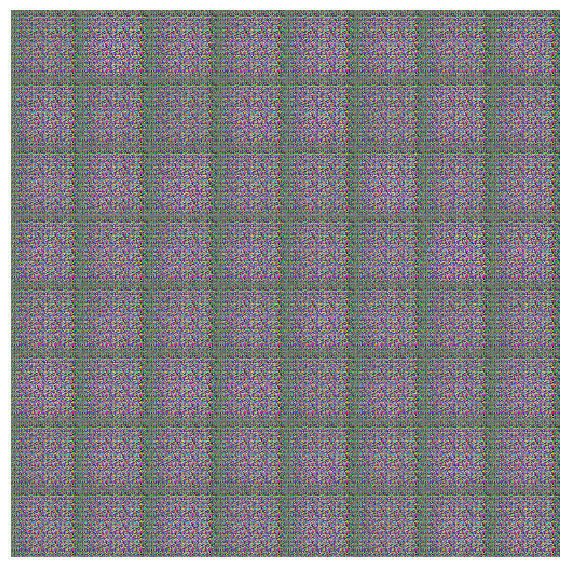

Epoch 11 / 250:
 generator loss 14.416125297546387 | discriminator loss 1.9171319007873535 
 generator loss 14.46021556854248 | discriminator loss 1.7864601612091064 
 generator loss 14.327435493469238 | discriminator loss 1.6972980499267578 
 generator loss 14.593369483947754 | discriminator loss 2.039829730987549 
 generator loss 14.44912338256836 | discriminator loss 2.045490264892578 


KeyboardInterrupt: 

In [16]:
for epoch in range(epochs):
    print("Epoch {} / {}:".format(epoch+1, epochs))

    for batch_number in range(number_of_batches):
        # 取得一批图片数据
        real_images = dataset_generator.next()
        # 将图片标准化至-1到1
        real_images = real_images / 127.5 - 1.

        # 每批大小不同，需每次计算该批数据量
        current_batch_size = real_images.shape[0]

        # 产生噪音
        noise = np.random.normal(0, 1, size=(current_batch_size,) + (1, 1, 100))

        # 使用生成器生成图片
        generated_images = generator.predict(noise)

        # 增加噪音扰乱鉴别器
        real_y = (np.ones(current_batch_size) - np.random.random_sample(current_batch_size) * 0.2)
        fake_y = np.random.random_sample(current_batch_size) * 0.2

        # 训练鉴别器
        discriminator.trainable = True

        d_loss = discriminator.train_on_batch(real_images, real_y)
        d_loss += discriminator.train_on_batch(generated_images, fake_y)

        discriminator_loss = np.append(discriminator_loss, d_loss)

        # 训练生成器
        discriminator.trainable = False

        noise = np.random.normal(0, 1,size=(current_batch_size * 2,) +(1, 1, 100))

        # 给予反向标签以误导鉴别器
        fake_y = (np.ones(current_batch_size * 2) -
                      np.random.random_sample(current_batch_size * 2) * 0.2)

        g_loss = gan.train_on_batch(noise, fake_y)
        adversarial_loss = np.append(adversarial_loss, g_loss)
    

        # 打印损失
        print(" generator loss {} | discriminator loss {} ".format(g_loss, d_loss))


    # 存储模型与生成图片
    if (epoch + 1) % 5 == 0:
        discriminator.trainable = True
        generator.save('models/generator_epoch' + str(epoch) + '.hdf5')
        discriminator.save('models/discriminator_epoch' +str(epoch) + '.hdf5')
        
        sample_images(generated_images, epoch)